# Convolutional Neural Networks

Recall that in previous notebooks to classify images we flattened them into long vectors as inputs to MLPs. This is unstatisfying since we are discarding important spatial information, i.e. observe that MLPs are invariant to a permutation of the neurons. In addition to this, a dense layer taking in a 256 x 256 RGB image producing a 256 x 256 x 3 image of the same dimensions would require around 39 billion parameters. This requires too much memory and results in excess capacity for a single layer.

It would be nice if we can include our prior knowledge that pixels are spatially related in some way into the structure of our networks. For tasks such as object detection and classification, we can abstract away two desirable properties: **translation invariance** and **locality**. For our purposes, we take "translation invariance" to mean that a transformation that is meaningful at a certain location should be also meaningful everywhere. In addition, we want the transformation to be local because since discriminative features for images typically exist only on localized regions, e.g. a dog's nose or cat ears, and looking at large regions of the image can potentially confuse the network.

In [102]:
import tensorflow as tf
from tensorflow import keras as kr
import numpy as np
import matplotlib.pyplot as plt

from inefficient_networks.config import config
config.set_tensorflow_seeds(0)
config.set_matplotlib()

## Convolution operation

In this section, we look at **convolution** which embody this idea of capturing local effects with a transformation that is somewhat translationally invariant. Convolution for a kernel $\mathbf K$ and an input image $\mathbf X$ is defined as

$$
(\mathbf X \circledast \mathbf K)_{ij} = \sum_{h = 1}^{k_1} \sum_{w=1}^{k_2} {\mathbf K}_{hw}\, {\mathbf X}_{i + h, j + w}.
$$

Observe that the kernel $\mathbf K$ is applied locally on a patch of size $k_1 \times k_2.$ The figure below show two convolution operations for 1-dimensional signals. Note that depending on the kernel, convolutions can be used to capture patterns (top), and also as differential operators (bottom). The latter can be useful for detecting features such as edges.


```{margin}
[[source]](https://fleuret.org/dlc/materials/dlc-handout-4-4-convolutions.pdf)
```
```{figure} ../../img/conv-effect.png
---
width: 40em
---
Convolution for 1-dimensional signals.
```



For neural networks, a **convolutional layer** replaces the dense operation with a convolution between the input tensor $\mathbf X$ and the weights $\mathbf W$ so that it implements the computation $\mathbf H = \varphi( u + \mathbf X \circledast \mathbf W)$ for a nonlinear activation $\varphi.$  This significantly reduces the size of the weight matrix. Since images have channels, we extend the 2-dimensional convolution layer to having an extra dimension indexed by $c_\text{out}$:

$$
\begin{aligned}
{\mathbf H}_{ij,\, c_\text{out}} 
&= \varphi\left(u_{c_\text{out}} + \sum_{h = 0}^{k_1-1} \sum_{w=0}^{k_2-1} {\mathbf K}_{hw,\,{c_\text{in}},\,{c_\text{out}}} \, {\mathbf X}_{i + h,\, j + w,\, c_\text{in}} \right)
\end{aligned}
$$

Here the first two indices for navigating along the spatial dimensions of the input image. This is done for each input channel, so we require a third dimension indexed by $c_{in}.$
Finally, we have such 3-dimensional tensors for each output channel, so that our final weight tensor is a 4-dimensional tensor. We can think of this geometrically as having $c_\text{out}$ filters of shape $(k_1, k_2, c_\text{in})$ which forms a $(k_1, k_2, c_\text{in}, c_\text{out})$ weight tensor. Note that if the input image $\mathbf X$ has spatial dimensions $H \times W$, then the resulting image $\mathbf H$ has spatial dimension $(H - h + 1) \times (W - w +1).$

<br>

```{margin}
[[Krizhevsky et. al.]](https://proceedings.neurips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html)
```

```{figure} ../../img/kernels_cnn.jpeg
---

---
Kernels learned by the first layer of AlexNet. Each of the 96 kernels shown here is of size 11x11x3,  shared by the 55x55 neurons in each of the 96 output channels. Note that most of these look like edge detectors.

Consistent with the above equation, TensorFlow expects input images to be of shape `(B, H, W, c)` for an batch input of size `B` of `H x W` images with `c` channels. Note that since these layers will be stacked, this is also expected the shape of output of a convolutional layer.

In [2]:
X = tf.random.normal(shape=(256, 28, 28, 1))             # (B, H_in, W_in, c_in)
conv = kr.layers.Conv2D(filters=3, kernel_size=(5, 5))   # [(5, 5, c_in, c_out), (c_out,)]

# Get out image, and check shapes
Y = conv(X)
K = conv.weights[0]
u = conv.weights[1]

# Check if implementation follows above formula
h, w = 5, 5
B, H, W, c = X.shape
H_out, W_out, c_out = H-h+1, W-w+1, 3
out = np.zeros(shape=(B, H_out, W_out, c_out))
for i in range(out.shape[1]):
    for j in range(out.shape[2]):
        XX = X.numpy()[:, i: i+h, j: j+w, :].reshape(B, -1)
        KK = K.numpy().reshape(h*w, -1)
        out[:, i, j, :] = u + (XX @ KK)

print(Y.shape)   # (B, H_out, W_out, c_out)
print(K.shape)   # (h, w, c_in, c_out)
print(u.shape)   # (c_out,)
print(np.abs(out - conv(X)).mean())

2022-04-27 18:58:11.474088: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-27 18:58:11.474354: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

(256, 24, 24, 3)
(5, 5, 1, 3)
(3,)
0.0


Note that the size of the output is 28 - 5  + 1 = 24. Next, we show that an example showing convolution is a **linear operation**. This can be shown directly from the definition, but here we show an actual construction of convolution as matrix multiplication. 

In [3]:
X = tf.convert_to_tensor(
    [[-1., 2.,-3.],
     [ 4.,-5., 6.],
     [-7., 8.,-9.],]
)[None, :, :, None]

K = tf.convert_to_tensor(
    [[-1.,  1.],
     [ 2., -2.]]
)[:, :, None, None]

conv_small = kr.layers.Conv2D(filters=1, kernel_size=(2, 2))
conv_small.build(input_shape=(256, 3, 3, 1))
conv_small.set_weights([K, tf.zeros(shape=(1,))])


X_ = np.array([-1., 2., -3., 4., -5., 6., -7., 8., -9.,])
K_ = np.array([
    [-1., 0., 0., 0.],
    [ 1.,-1., 0., 0.],
    [ 0., 1., 0., 0.],
    [ 2., 0.,-1., 0.],
    [-2., 2., 1.,-1.],
    [ 0.,-2., 0., 1.],
    [ 0., 0., 2., 0.],
    [ 0., 0.,-2., 2.],
    [ 0., 0., 0.,-2],
])

print((X_ @ K_).reshape(2, 2))
print()
print(tf.reshape(conv_small(X), (2, 2)).numpy())

[[ 21. -27.]
 [-39.  45.]]

[[ 21. -27.]
 [-39.  45.]]


### Stride and padding

The above definition of convolution can be modified to include a parameter $s$ called the **stride** that controls the step size of the kernel when it slides over the input image. A convolution layer with stride $s$ computes:

$$
\begin{aligned}
{\mathbf H}_{ij,\, c_\text{out}} 
&= \varphi\left(u_{c_\text{out}} + \sum_{h = 0}^{k_1-1} \sum_{w=0}^{k_2-1} {\mathbf K}_{hw,\,{c_\text{in}},\,{c_\text{out}}} \, {\mathbf X}_{si + h,\, sj + w,\, c_\text{in}} \right).
\end{aligned}
$$

This includes the original definition which has a step size of 1. It would be beneficial to use a larger stride along with a large kernel size if objects are large relative to the dimension of the image. For example, AlexNet {cite}`imagenet-paper` used a kernel of size 11 x 11 with a stride of 4 in the first layer since objects in the [ImageNet dataset](https://www.kaggle.com/c/imagenet-object-localization-challenge/overview/description) tend to occupy more pixels.

```{figure} ../../img/imagenet.jpeg
---
width: 45em
name: imagenet
---
Sample images from the ImageNet dataset. {cite}`imagenet`

```

**Padding.** Observe that in the above definition of convolution, the kernel placed entirely within the input image. This has the disadvantage of being biased towards the center pixels, resulting in information loss on the edges of the input image. Also notice that applying convolutions will always result in decreasing spatial dimension which limits the depth of the network. A simple fix is to simply pad the edges with zero, which gives us more space to place the kernel over the edges of the image.


```{margin}
[[source]](https://github.com/rasbt/machine-learning-book/blob/main/ch14/figures/14_05.png)
```
```{figure} ../../img/padding.png
---
width: 40em
---
```




<br>

This can implemented in TensorFlow using the `ZeroPadding2D` layer:

(256, 34, 34, 1)


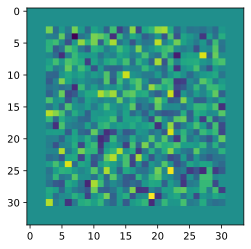

In [4]:
X = tf.random.normal(shape=(256, 28, 28, 1))            
pad = kr.layers.ZeroPadding2D(padding=3)

print(pad(X).shape)
plt.imshow(pad(X)[0, :, :, 0]);

### Output size

The spatial dimension of the output is directly influenced by padding `p` and stride `s`. Suppose the layer's input has width `W` and let the kernel have width `f`, then the output image has width `W_out = ⌊(W + 2p - f)/s⌋ + 1` assuming equal padding on both sides. 
Directly using discrete convolution is not always desirable as some pixels of the input are essentially dropped because a kernel cannot be placed within the image to cover them following the set stride:

```bash
input    1 2 3 4 5 6 7 8 9
kernel   0 0 1 0 0       
               0 0 1 0 0
         -----------------                     
output       3     6     
```

For odd kernel size `f` and unit stride `s = 1`, we can use `2p = f - 1` to get same sized outputs and with the kernel covering the entire input in a symmetric manner. For this reason, and also for the sake of symmetry, we [prefer odd-sized kernels](https://datascience.stackexchange.com/a/23186) for convolutions.

```bash
input    0 0 1 2 3 4 5 6 7 8 9 0 0
kernel   0 0 1 0 0
           0 0 1 0 0
                  ...
                       0 0 1 0 0
                         0 0 1 0 0
         -------------------------                        
output       1 2 3 4 5 6 7 8 9
```

For strides `s > 1`, the best practice is to choose a kernel size `f` and the smallest padding `p` such that `s` divides `W + 2p - f`. This way the entire input image is covered symmetrically by the kernel in constructing the convolved image.

```bash
input    0 1 2 3 4 5 6 7 8 9 0
kernel   0 0 1 0 0
               0 0 1 0 0
                     0 0 1 0 0
         ---------------------                         
output       2     5     8
```

**TF implementation.** The `padding` argument in `Conv2D` and other convolutional layers takes in either `"valid"` or `"same"`. The `"valid"` setting means that no padding is used an the kernel is placed only where it can be validly placed within the image. As discussed above this can result in discarding some pixels in the right as well as bottom part of the image. The `"same"` setting is a bit more tricky. Here the image is zero-padded as evenly as possible such that the output image has width `⌈W / s⌉`. So if `⌊(W + 2p - f) / s⌋ + 1 == ⌈W / s⌉`, such as when `s = 1` and `2p = f-1`, then we can use `"same"` to implement a symmetric construction of the output as described above using equal padding on both sides. Otherwise, we can use `ZeroPadding2D` or adjust the filter size as appropriate.

### Downsampling

For any unit `h` of a hidden layer, its **receptive field** refers to all the units from all the previous layers that may affect the calculation of `h` during forward pass. In particular, units in the final classification layer should have a receptive field that contains the whole input image in the input layer. Otherwise, some parts of the input data will not improve the performance of the model for that class. 

```{margin}
[[Lin et. al.]](https://www.researchgate.net/figure/The-receptive-field-of-each-convolution-layer-with-a-3-3-kernel-The-green-area-marks_fig4_316950618)
```
```{figure} ../../img/receptive_field.png
---
width: 18em
---
Receptive field of a pixel in the third layer.
```

One way to increase receptive field is by **downsampling** which is defined as taking a sample or aggregating samples in the current layer to pass a smaller input onto the next layer. This results in lower computational costs and a reduction in the capacity of the network which can be good. Downsampling is commonly done by means of a **pooling** operation. 

A pooling layer operates like a convolutional layer in that we can set a stride, padding, and kernel size. But unlike the convolution operation, pooling is non-parameteric. **Max-pooling** takes 
the maximum value in the region that is covered by its kernel. One effect of max pooling is that it provides invariance to small translations of the input at the cost of some information loss. Note that max-pooling works well with the ReLU activation so all values that are compared are of the same sign.

[[5 9]
 [4 8]]


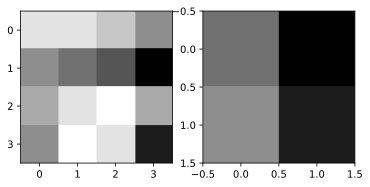

In [139]:
X = tf.convert_to_tensor([
    [ 1, 1, 2, 4],
    [ 4, 5, 6, 9],
    [ 3, 1, 0, 3],
    [ 4, 0, 1, 8]]
)[None, :, :, None]

pool = kr.layers.MaxPool2D(pool_size=2, strides=2)


plt.subplot(1, 2, 1)
plt.imshow(X.numpy()[0, :, :, 0], cmap='gray_r', vmin=0)

plt.subplot(1, 2, 2)
plt.imshow(pool(X).numpy().reshape(2, 2), cmap='gray_r', vmin=0)
print(pool(X).numpy().reshape(2, 2))

Note that pooling is applied to each channel separately, so that the number of output channels is maintained. This makes sense since we want only to compress the original input without affecting its semantic structure. 
In practice, there are two commonly used settings:`k=2` and `s=2` where the pooling regions are nonoverlapping, and the more aggressive overlapping pooling with `k=3` and `s=2`. Using larger kernel sizes can be too aggressive resulting in worse performance. Observe below that there is more information loss (loss in finer detail) when using overlapping pooling. 

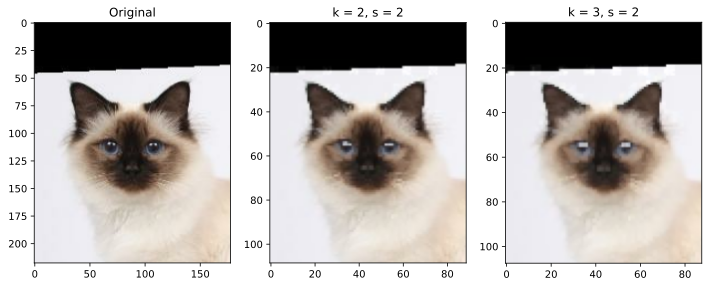

In [128]:
cat = config.DATASET_DIR / "cat.jpg"
image_raw = tf.io.read_file(str(cat))
image = tf.image.decode_image(image_raw)[None, :, :, :]

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(image[0, :, :, :])
ax[0].set_title("Original")
ax[1].imshow(kr.layers.MaxPool2D(pool_size=2, strides=2)(image)[0, :, :, :])
ax[1].set_title("k = 2, s = 2")
ax[2].imshow(kr.layers.MaxPool2D(pool_size=3, strides=2)(image)[0, :, :, :])
ax[2].set_title("k = 3, s = 2");

Another way to perform downsampling is by using strided convolution (with identity activation). This can be thought of as a pooling operation with learnable parameters for performing a weighted combination of pixel values.

## Implementing a convnet

Using the Keras sequential API, let us implement the following convolutional network for classifying [FashionMNIST](https://keras.io/api/datasets/fashion_mnist/) {cite}`fashion-mnist`. Note that we use a width of 512 instead of 1024 from the figure below to reduce network capacity. We also add batch normalization.

```{margin}
⚠️ **Attribution:** The next sections build on top of [these notebooks](https://github.com/rasbt/machine-learning-book/blob/main/ch14/) of {cite}`mlbook2022`. These notebooks are released under [MIT License](https://github.com/rasbt/machine-learning-book/blob/main/LICENSE.txt).
```
```{figure} ../../img/convnet.png
```

In [103]:
model = kr.Sequential([
    kr.layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu'),
    kr.layers.BatchNormalization(),
    kr.layers.MaxPooling2D(pool_size=2),
    kr.layers.Conv2D(filters=64, kernel_size=5, padding='same', activation='relu'),
    kr.layers.BatchNormalization(),
    kr.layers.MaxPooling2D(pool_size=2),
    kr.layers.Flatten(),
    kr.layers.Dense(512, activation='relu'),
    kr.layers.Dropout(rate=0.5),
    kr.layers.Dense(10, activation='softmax')
])

model.build(input_shape=(None, 28, 28, 1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 batch_normalization_2 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 64)        51264     
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                      

In [91]:
from tensorflow.keras.datasets import fashion_mnist

# Load and preprocess MNIST data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train = X_train.reshape((-1, 28, 28, 1))
X_train = X_train.astype('float32') / 255.0

X_test = X_test.reshape((-1, 28, 28, 1))
X_test = X_test.astype('float32') / 255.0


# Split train and validation sets
X_valid = X_train[:10000].copy()
y_valid = y_train[:10000].copy()

X_train = X_train[10000:]
y_train = y_train[10000:]


# Compile model with RMSProp and CE loss
model.compile(
    optimizer=kr.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

# Train model on FashionMNIST data
hist = model.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=64,
    validation_data=(X_valid, y_valid)
)

Epoch 1/20


2022-04-27 21:20:24.490059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - ETA: 0s - loss: 0.4940 - accuracy: 0.8295

2022-04-27 21:20:39.904278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 18s 19ms/step - loss: 0.4940 - accuracy: 0.8295 - val_loss: 0.3449 - val_accuracy: 0.8730
Epoch 2/20
782/782 [==============================] - 14s 18ms/step - loss: 0.3276 - accuracy: 0.8811 - val_loss: 0.2963 - val_accuracy: 0.8875
Epoch 3/20
782/782 [==============================] - 14s 18ms/step - loss: 0.2784 - accuracy: 0.8972 - val_loss: 0.2851 - val_accuracy: 0.8929
Epoch 4/20
782/782 [==============================] - 15s 19ms/step - loss: 0.2516 - accuracy: 0.9072 - val_loss: 0.2437 - val_accuracy: 0.9117
Epoch 5/20
782/782 [==============================] - 14s 18ms/step - loss: 0.2304 - accuracy: 0.9158 - val_loss: 0.2419 - val_accuracy: 0.9110
Epoch 6/20
782/782 [==============================] - 14s 18ms/step - loss: 0.2117 - accuracy: 0.9217 - val_loss: 0.2357 - val_accuracy: 0.9138
Epoch 7/20
782/782 [==============================] - 16s 20ms/step - loss: 0.1908 - accuracy: 0.9303 - val_loss: 0.2903 - val_accuracy: 0.9005
Epo

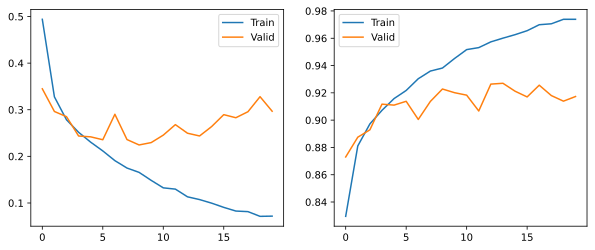

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(hist.history['loss'], label='Train')
ax[0].plot(hist.history['val_loss'], label='Valid')
ax[0].legend();

ax[1].plot(hist.history['accuracy'], label='Train')
ax[1].plot(hist.history['val_accuracy'], label='Valid')
ax[1].legend();

In [93]:
print(f"Test accuracy: {model.evaluate(X_test, y_test)[1]}")

313/313 [==============================] - 3s 9ms/step - loss: 0.3526 - accuracy: 0.9104
Test accuracy: 0.9104000329971313


Let us look at the model predictions:

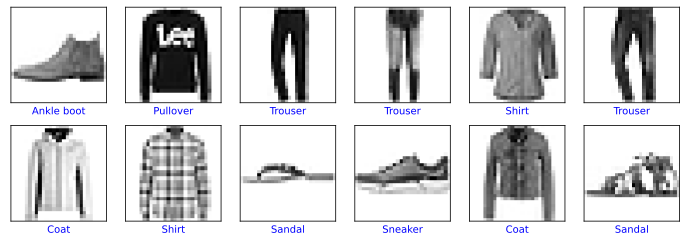

In [101]:
class_label = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    
    # Make prediction
    image = X_test[i]
    pred = np.argmax(model.predict(image[None, :, :, :]))
    
    # Plot
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image, cmap='gray_r')
    ax.set_xlabel(class_label[pred], color='blue')
    
plt.show()